<a href="https://colab.research.google.com/github/didi64/Colab_Test/blob/main/Classify_Reviews2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load the cleaned reviews and train an LSTM-model

In [1]:
import os, sys
from google.colab import drive
ROOT = '/content/drive/MyDrive/CAS_Gregi/'
MODULE_PATH = 'CO_modules/'
MODEL_PATH  = 'My_Models/'

IMPORT_PATH_SYMLINK = {'link': '/content/modules', 'target': ROOT + MODULE_PATH}

drive.mount('/content/drive', force_remount=False)
if not os.path.exists(IMPORT_PATH_SYMLINK['link']):
    os.symlink(IMPORT_PATH_SYMLINK['target'], IMPORT_PATH_SYMLINK['link'])
if IMPORT_PATH_SYMLINK['link'] not in sys.path:
    sys.path.insert(0, IMPORT_PATH_SYMLINK['link'])

Mounted at /content/drive


In [ ]:
2!ls -l {IMPORT_PATH_SYMLINK['link']}
!ls /content $ROOT /content/drive {IMPORT_PATH_SYMLINK['link']}

In [2]:
import pickle
with open(ROOT + 'data/hotelreviews_cleaned_train_test_spell.pkl','rb') as f:
    data_train, data_test = pickle.load(f)

In [3]:
import random
import numpy as np
import tensorflow as tf
from functools import reduce

In [4]:
def fix_shape(text):
    return tf.constant(text, shape = (1,))

def get_dataset(d):
    ''' get dataset from dict {score: list_of_revies,...}'''
    # list of tuples [(score, review),...]
    all_reviews = reduce(lambda x,y: x + y, [[(r, k) for k,v in d.items() for r in v]])
    random.shuffle(all_reviews)
    reviews = tf.constant([r for r,_ in all_reviews], shape=(len(all_reviews), 1))
    gpt_scores  = tf.constant([s - 1 for _, s in all_reviews])

    n = len(reviews)
    ds = tf.data.Dataset.from_tensor_slices((reviews[:n], gpt_scores[:n]))
    return ds

def batch(ds, batch_size = 32):
    xs, ys =  next(iter(ds))
    if xs.shape == () or xs.shape[0] == 1:
        ds = ds.batch(batch_size)
    return ds

def test_model(model, ds):
    i = 0
    for xs, _ in iter(ds):
        i += 1
        if (i %10) ==0:
            print(i, end = ', ')
        model(xs)

In [5]:
ds_train = batch(get_dataset(data_train))
ds_test  = batch(get_dataset(data_test))

In [6]:
all_reviews = reduce(lambda x,y: x + y, [[(r, k) for d in (data_train, data_test) for k,v in d.items() for r in v]])
WORDS = reduce(lambda x,y:x|y, [set(x[0].split()) for x in all_reviews])

In [7]:
# Vocab Size, number of review, fraction of reviews with more than 200 words
len(WORDS), len(all_reviews), len([nwords for x in all_reviews if (nwords := len(x[0].split())) > 200])/len(all_reviews)

(9033, 6000, 0.029)

In [8]:
# standardization: one element of  standardizations or a callable mapping strings to strings
standardizations = [None, "lower_and_strip_punctuation", "lower", "strip_punctuation"]
max_tokens = len(WORDS) + 2 # number of words plus the tokens '' and '[UNK]'
ngrams = None
sequence_length = 200

tv_layer = tf.keras.layers.TextVectorization(
    max_tokens = max_tokens,
    standardize = standardizations[0],
    ngrams=ngrams,
    output_mode='int',
    output_sequence_length = sequence_length,
    pad_to_max_tokens=True,
)

In [9]:
tv_layer.adapt([r[0] for r in all_reviews])
vocab = tv_layer.get_vocabulary()
len(vocab),  vocab[:5]# max_tokens

(9035, ['', '[UNK]', 'the', 'and', 'was'])

In [10]:
tv_layer(data_train[3][30])

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([  16,    8,  436,   82,  163,    5,  365,  222,   37,   21,    2,
        377,  259,   36,   20,    5,  276,   10,  104, 2640,   21,    2,
        377,  466,   16,   20,  528,    2,  207,   55,    5,  118,  275,
          3,   44,  105,  210,  192, 1695,    6,  316,    8,    2,  115,
          7,   13,    2,   94,   25,   65,  264,   42,  367,    3,  586,
          5,  664,    4,  392,    8,    2,    7,   36,   14,   40, 1155,
        107,  316,   17,  429,   29,  296,    5,  531,    3,    5,  357,
        113,   28,   89,   28,  291,  398,    6, 4099,    5, 1109, 3744,
          2,    7,    4,   52,    3,  722,    3,    2,   41,    4,   98,
         30,  106,  544,    8,    2,   67,    3,  738,  585, 1656,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

In [11]:
vocab[16], vocab[8], vocab[436], data_train[3][30].split()[:3]

('it', 'in', 'located', ['it', 'in', 'located'])

In [12]:
output_dim =  16
em_layer = tf.keras.layers.Embedding(input_dim = max_tokens + 1, output_dim= output_dim)
em_layer(tv_layer('what a hotel'))

<tf.Tensor: shape=(200, 16), dtype=float32, numpy=
array([[ 0.04440754,  0.02392682, -0.01466876, ...,  0.03683814,
         0.01358436,  0.03030736],
       [ 0.0405605 ,  0.02802445, -0.04899242, ...,  0.00619482,
         0.03192169,  0.02515126],
       [-0.02941049, -0.02947937,  0.03633921, ..., -0.0321173 ,
         0.03721592, -0.00445818],
       ...,
       [-0.00935967, -0.02654995, -0.02797369, ...,  0.04378435,
        -0.02251643, -0.02020776],
       [-0.00935967, -0.02654995, -0.02797369, ...,  0.04378435,
        -0.02251643, -0.02020776],
       [-0.00935967, -0.02654995, -0.02797369, ...,  0.04378435,
        -0.02251643, -0.02020776]], dtype=float32)>

In [13]:
lstm = tf.keras.layers.LSTM(10)
lstm_bi = tf.keras.layers.Bidirectional(lstm, merge_mode='concat')

model = tf.keras.Sequential([
    tv_layer,
    em_layer,
    tf.keras.layers.Dropout(0.2),
    lstm_bi,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'relu')], name = 'lstm_bi10')
model.summary()

Model: "lstm_bi10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 16)           144576    
                                                                 
 dropout (Dropout)           (None, 200, 16)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 20)               2160      
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 flatten (Flatten)           (None, 20)                0 

In [30]:
conv1d_1f = tf.keras.layers.Conv1D(
    filters = 1,
    kernel_size = 8,
    strides=1,
    padding='same',
    data_format='channels_last',
    dilation_rate=1,
    groups=1,
    activation='relu',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
)

model_conv_1f = tf.keras.Sequential([
    tv_layer,
    em_layer,
    tf.keras.layers.Dropout(0.2),
    conv1d_1f,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'relu')], name = 'conv1d_1f')
model_conv_1f.summary()

Model: "conv1d_1f"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 16)           144576    
                                                                 
 dropout_9 (Dropout)         (None, 200, 16)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 200, 1)            129       
                                                                 
 dropout_10 (Dropout)        (None, 200, 1)            0         
                                                                 
 flatten_3 (Flatten)         (None, 200)               0         
                                                         

In [39]:
conv1d_8f = tf.keras.layers.Conv1D(
    filters = 8,
    kernel_size = 8,
    strides=1,
    padding='same',
    data_format='channels_last',
    dilation_rate=1,
    groups=1,
    activation='relu',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
)

model_conv_8f = tf.keras.Sequential([
    tv_layer,
    em_layer,
    tf.keras.layers.Dropout(0.2),
    conv1d_1f,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'relu')], name = 'conv1d_8f')
model_conv_8f.summary()

Model: "conv1d_8f"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 16)           144576    
                                                                 
 dropout_15 (Dropout)        (None, 200, 16)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 200, 1)            129       
                                                                 
 dropout_16 (Dropout)        (None, 200, 1)            0         
                                                                 
 flatten_5 (Flatten)         (None, 200)               0         
                                                         

In [14]:
metric = tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error', dtype=None)
loss =  tf.keras.losses.MeanSquaredError()
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=loss,
    metrics=[metric],
)

In [34]:
model_conv_1f.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=loss,
    metrics=[metric],
)

In [41]:
model_conv_8f.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=loss,
    metrics=[metric],
)

In [15]:
# test if reviews pass through model, show sample output
for ds in (ds_train, ds_test):  test_model(model, ds)

10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 10, 20, 30, 

In [22]:
def save_model(model):
    model_path = ROOT + MODEL_PATH + model.name +'/'
    if not os.path.exists(ROOT + model_path):
        os.makedirs(ROOT + model_path, exist_ok = False)
        print('Created directory ' + ROOT + model_path)

    model.save(model_path + model.name + '_save', save_format='tf')

def load_model(model):
    model_path = ROOT + MODEL_PATH + model.name +'/'
    model = tf.keras.models.load_model(model_path + model.name + '_save')
    return model

In [105]:
# load from checkpoint
# model.load_weights(model_path + 'checkpoints')

In [31]:
def model_fit(model, train, test, epochs):

    model_path = ROOT + MODEL_PATH + model.name +'/'
    if not os.path.exists(ROOT + model_path):
        os.makedirs(ROOT + model_path, exist_ok = False)
        print('Created directory ' + ROOT + model_path)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path + 'checkpoints',
        save_weights_only=True,
        monitor='mean_absolute_error',
        mode='min',
        save_best_only=True)


    if os.path.exists(model_path + 'current_weights.index'):
        model.load_weights(model_path + 'current_weights')
        print('Found previous weights')
    else:
        print('No previous weights found!')

    history =  model.fit(
        train,
        epochs = epochs,
        validation_data = test,
        callbacks=[model_checkpoint_callback]
    )

    model.evaluate(ds_test)
    model.save_weights(model_path + 'current_weights', save_format='tf')
    print('Current weights saved to ' + model_path + 'current_weights')

    return history

In [ ]:
history_conv_1f = model_fit(model_conv_1f, train=ds_train, test=ds_test, epochs=500)

In [42]:
history_conv_8f = model_fit(model_conv_8f, train=ds_train, test=ds_test, epochs=500)

No previous weights found!
Epoch 1/500
157/157 [==============================] - 21s 129ms/step - loss: 1.5777 - mean_absolute_error: 0.8354 - val_loss: 0.8056 - val_mean_absolute_error: 0.7019
Epoch 2/500
157/157 [==============================] - 1s 6ms/step - loss: 0.3605 - mean_absolute_error: 0.4703 - val_loss: 0.7216 - val_mean_absolute_error: 0.6525
Epoch 3/500
157/157 [==============================] - 2s 11ms/step - loss: 0.2678 - mean_absolute_error: 0.4030 - val_loss: 0.6755 - val_mean_absolute_error: 0.6339
Epoch 4/500
157/157 [==============================] - 1s 7ms/step - loss: 0.2237 - mean_absolute_error: 0.3701 - val_loss: 0.6647 - val_mean_absolute_error: 0.6275
Epoch 5/500
157/157 [==============================] - 1s 6ms/step - loss: 0.2006 - mean_absolute_error: 0.3448 - val_loss: 0.6601 - val_mean_absolute_error: 0.6235
Epoch 6/500
157/157 [==============================] - 1s 6ms/step - loss: 0.1865 - mean_absolute_error: 0.3356 - val_loss: 0.6507 - val_mean_ab

In [28]:
# model.save_weights(model_path + 'weights_after_1000_epochs', save_format='tf')

In [54]:

# next(iter(ds_train))

In [23]:
# save model
save_model(model)

Created directory /content/drive/MyDrive/CAS_Gregi//content/drive/MyDrive/CAS_Gregi/My_Modelslstm_bi10/


In [ ]:
# load the model
# model = load_model(model)

In [27]:
model.evaluate(ds_test)

32/32 [==============================] - 0s 13ms/step - loss: 0.4172 - mean_absolute_error: 0.4113


[0.41715019941329956, 0.4113498330116272]

In [18]:
def accuracy(ds):

    ys_pred = (model.predict(ds).reshape((-1,))).round()
    ys = np.concatenate([y for x, y in ds], axis=0)
    errs = abs(ys - ys_pred)
    N = len(ys)
    relative_hits = [np.count_nonzero(errs==i)/N for i in range(5)]
    return relative_hits

def np_accuracy(ds):
    f = lambda x:x<0 and -1 or x>0 and 1 or 0
    ys_pred = (model.predict(ds).reshape((-1,))).round() - 2
    ys_pred = np.array([f(x) for x in ys_pred])
    ys = np.concatenate([y for x, y in ds], axis=0) - 2
    ys = np.array([f(x) for x in ys])

    errs = abs(ys - ys_pred)
    N = len(ys)
    relative_hits = [np.count_nonzero(errs==i)/N for i in [0,1,2]]
    return relative_hits

In [19]:
accuracy(ds_train), accuracy(ds_test)

32/32 [==============================] - 0s 8ms/step


([1.0, 0.0, 0.0, 0.0, 0.0], [0.659, 0.301, 0.036, 0.004, 0.0])

In [31]:
accuracy(ds_train), accuracy(ds_test)

32/32 [==============================] - 0s 10ms/step


([0.999, 0.001, 0.0, 0.0, 0.0], [0.656, 0.306, 0.034, 0.004, 0.0])

In [33]:
text = fix_shape('the best hotel i ever stayed at')
model.predict(text)

1/1 [==============================] - 0s 28ms/step


array([[2.2713227]], dtype=float32)

In [35]:
text = '''
the breakfast was excellent and the room very clean and spacious
the staff was very friendly
I can really recommend this place'''.lower().replace('\n', ' ')
model.predict(fix_shape(text))

1/1 [==============================] - 0s 25ms/step


array([[3.428855]], dtype=float32)

In [39]:
text = '''\
the breakfast was ok, but nothing special
the staff was very friendl.
But the room we small and not suitable for working'''.lower().replace('\n', ' ')

model.predict(fix_shape(text))

1/1 [==============================] - 0s 36ms/step


array([[2.32862]], dtype=float32)

In [40]:
text = '''\
the breakfast was ok, but nothing special
the staff was quite rude
And the room we small and not suitable for working'''.lower().replace('\n', ' ')
model.predict(fix_shape(text))

1/1 [==============================] - 0s 24ms/step


array([[1.7753965]], dtype=float32)

In [41]:
text = '''\
the breakfast was bad, only bread and coffe
Checkin took forever
No roomservice
The room we small and not suitable for working'''.lower().replace('\n', ' ')
model.predict(fix_shape(text))

1/1 [==============================] - 0s 24ms/step


array([[2.0958402]], dtype=float32)

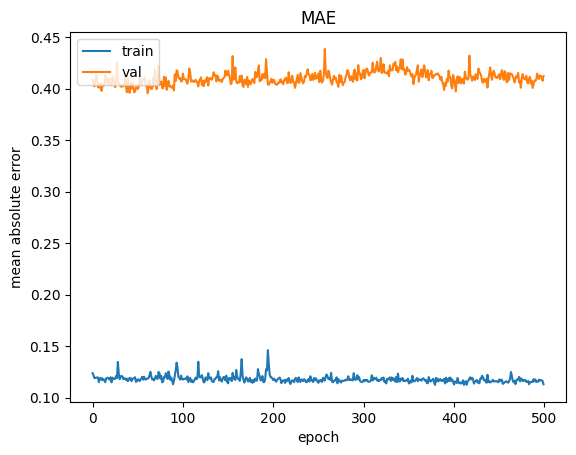

In [20]:
from matplotlib import pyplot as plt
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

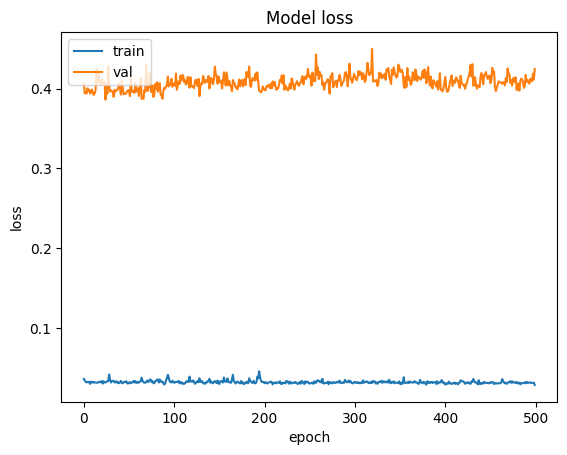

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()